In [1]:
import textwrap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.special as sp
from scipy import integrate, signal, optimize
import math
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [2]:
# defining regulatory functions and their derivatives

f = lambda a: 1 / (1 + (a/a_n)**2) # regulatory function for k_n
f_prime = lambda a: -2*a/a_n**2 / (1 + (a/a_n)**2)**2 # derivative of f w.r.t. a

g = lambda a: (a/a_t)**2 / (1 + (a/a_t)**2) # regulatory function for k_t
g_prime = lambda a: 2*a/a_t**2 / (1 + (a/a_t)**2)**2 # derivative of g w.r.t. a

# f_R, the fraction of total cell synthesis capacity devoted to ribosome production
f_R = lambda a: -f_prime(a)*g(a)*phiR_max / (-f_prime(a)*g(a) + f(a)*g_prime(a))

In [3]:
# ribosome mass fraction ODE (for m ribosomal timescales)

def dphiR_dt_m(phi_Rm, t, phi_R, phi_Rm_all, a, m, lam, pi):
    k = scale*(1 - np.abs(2*pi-1))
    C = cm(lam,k)
    k_t = k_t0 * g(a) # translational efficiency

    dpdt_m = k_t*C[m]*f_R(a)*phi_R - phi_Rm*GrowthRate(a,phi_Rm_all,lam) - phi_Rm / lam[m]
    return dpdt_m

In [4]:
# amino acid concentration ODE (variable nutrient conc.(c))

def dAAdt(a, t, phi_R, phi_Rm_all, lam_all, pi):
    k = scale*(1 - np.abs(2*pi-1))

    k_n = k_n0(t) * f(a) # nutritional efficiency, depends on concentration of nutrients outside cell
    k_t = k_t0 * g(a) # translational efficiency

    dadt = k_n * (phiR_max - phi_R) - GrowthRate(a,phi_Rm_all,lam_all)
    return dadt

In [5]:
def dPidt(pi, t):
    return rho*(c(t) - pi)

In [6]:
# defining growth rate function

def GrowthRate(a, phi_Rm_all, lam_all):

    if len(phi_Rm_all.shape) == 1:
        k_t = k_t0 * g(a) # translational efficiency
        k=0
        for lam_m,phi_Rm in zip(lam_all,phi_Rm_all):
            k += (k_t - 1/lam_m)*phi_Rm
    else:
        k = np.zeros((a.shape))
        for i in range(len(a)):
            j=0
            for lam_m,phi_Rm in zip(lam_all,phi_Rm_all[i,:]):
                j += (k_t0*g(a[i]) - 1/lam_m)*phi_Rm
            k[i] = j

    return k

In [8]:
# parameters

phiR_max = 0.55 # Scott et al. 2010

a_n = 1e-3 # level to trigger negative feeback inhibition of amino acid supply, Scott et al. 2014
a_t = 1e-4 # amino acid level for efficient peptide elongation, Scott et al. 2014

n_f = 2
n_g = 2

In [9]:
def RunAndPlotGrowth(simulation_max, n_points, C_init):

    t = np.linspace(t0,simulation_max,n_points)
    h = (simulation_max-t0)/n_points

    species_0 = np.zeros(n_timescales+2)
    for i in range(n_timescales):
        species_0[i] = phi_R0 * C_init[i]
    species_0[-2] = a0

    # Numerically solving the coupled ODEs
    species = integrate.odeint(odes, species_0, t, args=(h,))

    t, kappa = PlotGrowth(species, t)

    return t,kappa

### Figure 4d, fluctuating environment

In [ ]:
# packing coupled ODEs together to be solved by odeint

def odes(Species, t, h):

    phi_R = np.sum(Species[0:n_timescales], axis=0)
    phiRm_all = Species[0:n_timescales]
    a = Species[-2]
    pi = Species[-1]
    a_ode = dAAdt(a, t, phi_R, phiRm_all, lam, pi)
    pi_ode = dPidt(pi, t)

    dSpeciesdt = np.zeros(np.shape(Species))
    for i in range(n_timescales): # phi_Rm1,phi_Rm2,phi_Rm3,a = Species
        phi_Rm = Species[i]
        dSpeciesdt[i] = dphiR_dt_m(phi_Rm, t, phi_R, phiRm_all, a, i, lam, pi)

    dSpeciesdt[-2] = a_ode
    dSpeciesdt[-1] = pi_ode
    return dSpeciesdt

In [10]:
# modified plot function for visualizing fluxes and f_R(t) as well

def PlotGrowth(Species, Time):
    fig = plt.figure()
    colors = plt.cm.Greens(np.linspace(0.6, 1, n_timescales))

    # Unpacking the Species matrix
    phi_Rm_all = Species[:,0:n_timescales]
    a = Species[:,-2]
    pi = Species[:,-1]
    k = scale*(1 - np.abs(2*pi-1))

    # Plot Layout
    fig, ax1 = plt.subplots(3,1, figsize=(6,6.5))
    plt.xlabel('Time (h)')
    nper = 5

    # Plot 1
    for i in range(n_timescales):
        c_m=[]
        for j,t in enumerate(Time):
            c_m.append(cm(lam,k[j])[i])
        ax1[0].plot(Time,c_m, color=colors[i], label=lam[i])
    start=0
    for i in range(nper):
        ax1[0].axvspan(start+period/2,start+period, facecolor='0.2', alpha=0.2)
        start = start + period
    label = 'Allocation Fraction, $c_m$'
    wrapped_text = "\n".join(textwrap.wrap(label, width=19))
    ax1[0].set_ylabel(wrapped_text)
    # ax1[0].set_yscale('log')
    ax1[0].legend(title='$\lambda_m$ (h)')
    ax1[0].set_xlim(0,max(Time))
    ax1[0].set_xticks([])  # Hide x-axis ticks
    ax1[0].set_xticklabels([])  # Hide x-axis tick labels

    # Plot 2
    for i in range(n_timescales):
        phi_Rm = Species[:,i]
        ax1[1].plot(Time, phi_Rm, color=colors[i])
    start=0
    for i in range(nper):
        ax1[1].axvspan(start+period/2,start+period, facecolor='0.2', alpha=0.2)
        start = start + period
    label = 'Subsector Allocation, $\phi_R^m$'
    wrapped_text = "\n".join(textwrap.wrap(label, width=20))
    ax1[1].set_ylabel(wrapped_text)
    ax1[1].set_xlim(0,max(Time))
    ax1[1].set_xticks([])  # Hide x-axis ticks
    ax1[1].set_xticklabels([])  # Hide x-axis tick labels

    # Plot 3
    ax1[2].plot(Time, GrowthRate(a, phi_Rm_all, lam), color='k')
    ax1[2].set_xlim(0,max(Time))
    start=0
    for i in range(nper):
        ax1[2].axvspan(start+period/2,start+period, facecolor='0.2', alpha=0.2)
        start = start + period
    plt.setp(ax1[2], ylabel='Growth Rate (h$^{-1}$)')

    # ax1[3].plot(Time, pi)
    # ax1[3].set_xlim(0,max(Time))

    plt.subplots_adjust(hspace=.0)
    # fig.savefig('Figures/Fluctuating Paper/subsector-pulsatile.pdf', dpi=300, bbox_inches='tight')

    return Time, GrowthRate(a, phi_Rm_all, lam)

In [11]:
# concentration function
k_n0 = lambda t: (kn0_high - kn0_low) * (signal.square(2*np.pi*t/period + np.pi)/2 + 0.5) + kn0_low - (kn0_high - kn0_low) * (signal.square(2*np.pi*t/period + np.pi)/2 + 0.5) * np.heaviside(t_shift - t, 0.5)
c = lambda t: signal.square(2*np.pi*t/period + np.pi)/2 + 0.5 - (signal.square(2*np.pi*t/period + np.pi)/2 + 0.5)*np.heaviside(t_shift-t,0.5)

# allocation fraction function
def cm(lam,k):
    C = np.zeros(np.shape(lam))
    for m in range(len(lam)):
        C[m] = lam[m]**(1-k) / np.sum(lam**(1-k))
    return C

<Figure size 640x480 with 0 Axes>

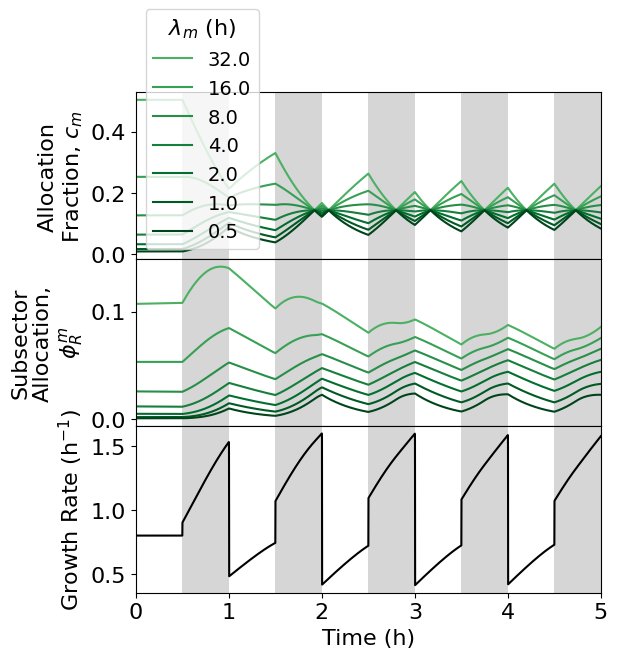

In [12]:
period = 1
simulation_max = 5 # in hrs

kn0_low = 2.5
kn0_high = 70
k_t0 = 4.5
rho = 1
scale = 1

lam = np.array([32,16,8,4,2,1,0.5])
C = cm(lam, k=0.5)
n_timescales = len(lam)

t0 = -3
n_points = 10000 #number of simulation points
t_shift = 0

# solving for initial conditions to produce steady state
# root = optimize.fsolve(func, [1e-4, 0.4], args=(lam,C)) # requires guess of initial conditions
# phi_R0 = root[1] # initial proteome fraction
# a0 = root[0] # initial amin acid concentration
phi_R0 = 0.24
a0 = 3.25e-4

plt.rc('font', size=16)
plt.rc('legend', fontsize=14)
t1,kappa1 = RunAndPlotGrowth(simulation_max, n_points, C)

### Figure 4c, single shift

In [13]:
c = lambda t: np.heaviside(t-t_shift,0.5)
k_n0 = lambda t: (kn0_high - kn0_low)*np.heaviside(t-t_shift,0.5) + kn0_low

In [14]:
# packing coupled ODEs together to be solved by odeint

def odes(Species, t, h):

    phi_R = np.sum(Species[0:n_timescales], axis=0)
    phiRm_all = Species[0:n_timescales]
    a = Species[-2]
    pi = Species[-1]
    pi_bias = 1 + beta*(pi - 1)
    a_ode = dAAdt(a, t, phi_R, phiRm_all, lam, pi_bias)
    pi_ode = dPidt(pi, t)

    dSpeciesdt = np.zeros(np.shape(Species))
    for i in range(n_timescales): # phi_Rm1,phi_Rm2,phi_Rm3,a = Species
        phi_Rm = Species[i]
        dSpeciesdt[i] = dphiR_dt_m(phi_Rm, t, phi_R, phiRm_all, a, i, lam, pi_bias)

    dSpeciesdt[-2] = a_ode
    dSpeciesdt[-1] = pi_ode
    return dSpeciesdt

In [15]:
# modified plot function for visualizing fluxes and f_R(t) as well

def PlotGrowth(Species, Time):
    fig = plt.figure()
    colors = plt.cm.Greens(np.linspace(0.6, 1, n_timescales))
    # lsytle = ['-','--','-.']

    # Unpacking the Species matrix
    phi_Rm_all = Species[:,0:n_timescales]
    a = Species[:,-2]
    pi = Species[:,-1]
    pi_bias = 1 + beta*(pi - 1)
    k = scale*(1 - np.abs(2*pi_bias-1))

    # Plot Layout
    fig, ax1 = plt.subplots(3,1, figsize=(6,6.5))
    plt.xlabel('Time (h)')
    ub = 4.2

    # Plot 1
    for i in range(n_timescales):
        c_m=[]
        for j,t in enumerate(Time):
            c_m.append(cm(lam,k[j])[i])
        ax1[0].plot(Time,c_m, color=colors[i], label=lam[i])
    ax1[0].axvspan(t_shift,simulation_max, facecolor='0.2', alpha=0.2)
    label = 'Allocation Fraction, $c_m$'
    wrapped_text = "\n".join(textwrap.wrap(label, width=19))
    ax1[0].set_ylabel(wrapped_text)
    # ax1[0].set_yscale('log')
    ax1[0].legend(title='$\lambda_m$ (h)')
    ax1[0].set_xlim(0,ub)
    ax1[0].set_xticks([])  # Hide x-axis ticks
    ax1[0].set_xticklabels([])  # Hide x-axis tick labels

    # Plot 2
    for i in range(n_timescales):
        phi_Rm = Species[:,i]
        ax1[1].plot(Time, phi_Rm, color=colors[i])
    ax1[1].axvspan(t_shift,simulation_max, facecolor='0.2', alpha=0.2)
    label = 'Subsector Allocation, $\phi_R^m$'
    wrapped_text = "\n".join(textwrap.wrap(label, width=19))
    ax1[1].set_ylabel(wrapped_text)
    # ax1[1].set_yscale('log')
    ax1[1].set_xlim(0,ub)
    ax1[1].set_xticks([])  # Hide x-axis ticks
    ax1[1].set_xticklabels([])  # Hide x-axis tick labels

    # Plot 3
    ax1[2].plot(Time, GrowthRate(a, phi_Rm_all, lam), color='k')
    ax1[2].set_xlim(0,ub)
    ax1[2].axvspan(t_shift,simulation_max, facecolor='0.2', alpha=0.2)
    plt.setp(ax1[2], ylabel='Growth Rate (h$^{-1}$)')

    plt.subplots_adjust(hspace=.0)
    # fig.savefig('Figures/Fluctuating Paper/subsector-single.pdf', dpi=300, bbox_inches='tight')
    return Time, GrowthRate(a, phi_Rm_all, lam)

<Figure size 640x480 with 0 Axes>

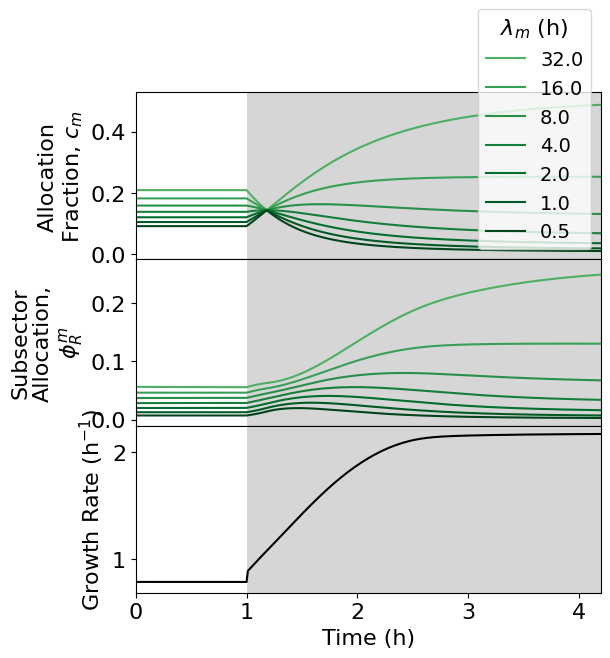

In [16]:
beta = 0.6

kn0_low = 2.5 #5
kn0_high = 70 #1000
k_t0 = 4.5
rho = 1
scale = 1

lam = np.array([32,16,8,4,2,1,0.5])
C = cm(lam, k=0.5)
n_timescales = len(lam)
simulation_max = 9 # in hrs
t0 = -3
n_points = 1000 #number of simulation points
t_shift = 1

# solving for initial conditions to produce steady state
# root = optimize.fsolve(func, [1e-4, 0.4], args=(lam,C)) # requires guess of initial conditions
# phi_R0 = root[1] # initial proteome fraction
# a0 = root[0] # initial amin acid concentration
phi_R0 = 0.24
a0 = 3.25e-4

plt.rc('font', size=16)
plt.rc('legend', fontsize=14)
tsingle,kappasingle = RunAndPlotGrowth(simulation_max, n_points, C)

#### Figure 5a, constant memory

In [17]:
# modified plot function for visualizing fluxes and f_R(t) as well

def PlotGrowth(Species, Time):

    # Unpacking the Species matrix
    phi_R = np.sum(Species[:,0:n_timescales], axis=1)
    a = Species[:,-1]

    # Plot
    i = np.where(Time > 3.9)[0][0]
    kappa = GrowthRate(a, phi_R, lam, C)
    plt.plot(Time, kappa/kappa[i], label=k, color=color)
    # plt.plot(Time, kappa)

In [18]:
def RunAndPlotGrowth(simulation_max, n_points):

    t = np.linspace(-3,simulation_max,n_points)

    species_0 = np.zeros(n_timescales+1)
    for i in range(n_timescales):
        species_0[i] = phi_R0 * C[i]
    species_0[-1] = a0

    # Numerically solving the coupled ODEs
    species = integrate.odeint(odes, species_0, t)

    PlotGrowth(species, t)

In [19]:
# allocation fraction function
def cm(lam):
    C = np.zeros(np.shape(lam))
    for m in range(len(lam)):
        C[m] = lam[m]**(1-k) / np.sum(lam**(1-k))
    return C

In [20]:
# amino acid concentration ODE (variable nutrient conc.(c))

def dAAdt(a, t, phi_R, lam_all, C_all):

    k_n = k_n0(t) * f(a) # nutritional efficiency, depends on concentration of nutrients outside cell
    k_t = k_t0 * g(a) # translational efficiency

    dadt = k_n * (phiR_max - phi_R) - GrowthRate(a,phi_R,lam_all,C_all)
    return dadt

In [21]:
# ribosome mass fraction ODE (for m ribosomal timescales)

def dphiR_dt_m(phi_Rm, t, phi_R, a, m, lam, C):
    k_t = k_t0 * g(a) # translational efficiency

    dpdt_m = k_t*C[m]*f_R(a)*phi_R - phi_Rm*GrowthRate(a,phi_R,lam,C) - phi_Rm / lam[m]
    return dpdt_m

In [22]:
# defining growth rate function

def GrowthRate(a, phi_R, lam_all, C_all):

    k_t = k_t0 * g(a) # translational efficiency

    k = (k_t - np.sum(C_all / lam_all)) * phi_R

    return k

In [23]:
# packing coupled ODEs together to be solved by odeint

def odes(Species, t):

    phi_R = np.sum(Species[0:n_timescales], axis=0)
    a = Species[-1]
    a_ode = dAAdt(a, t, phi_R, lam, C)

    dSpeciesdt = np.zeros(np.shape(Species))
    for i in range(n_timescales): # phi_Rm1,phi_Rm2,phi_Rm3,a = Species
        phi_Rm = Species[i]
        dSpeciesdt[i] = dphiR_dt_m(phi_Rm, t, phi_R, a, i, lam, C)

    dSpeciesdt[-1] = a_ode
    return dSpeciesdt

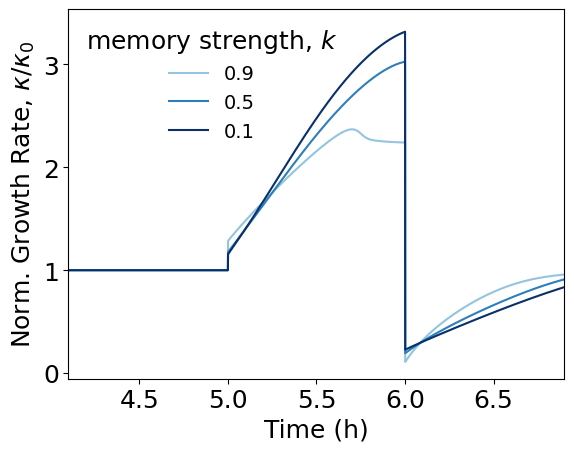

In [24]:
kn0_low = 2
kn0_high = 50
k_t0 = 6

lam = np.array([4, 0.5, 0.1])
mem = [0.9,0.5,0.1]
colors = plt.cm.Blues(np.linspace(0.4, 1, len(mem)))

simulation_max = 9 # in hrs
n_points = 100000 #number of simulation points
period = 2

# concentration function
# k_n0 = lambda t: (kn0_high - kn0_low) * (signal.square(2*np.pi*t/period + np.pi)/2 + 0.5) + kn0_low
t_shift = 5
k_n0 = lambda t: (kn0_high - kn0_low) * (signal.square(2*np.pi*t/period + np.pi)/2 + 0.5) + kn0_low - (kn0_high - kn0_low) * (signal.square(2*np.pi*t/period + np.pi)/2 + 0.5) * np.heaviside(t_shift - t, 0.5)


fig = plt.figure()
plt.rc('font', size=18)
plt.rc('legend', fontsize=14)
for k,color in zip(mem, colors):

    C = cm(lam)
    n_timescales = len(lam)

    phi_R0 = 0.24
    a0 = 3.25e-4

    RunAndPlotGrowth(simulation_max, n_points)
plt.legend(title='memory strength, $k$', frameon=False)
plt.ylabel('Norm. Growth Rate, $\kappa/\kappa_0$')
plt.xlabel('Time (h)')
plt.xlim(4.1,6.9)
plt.show()
# fig.savefig('Figures/Fluctuating Paper/growth_vs_adaptation.pdf', dpi=300, bbox_inches='tight')